In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

file_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'steam_data_2021_2025.csv')
df = pd.read_csv(file_path)
print(df.head())

     appid                        name  release_year  release_date  \
0  3057270           Seafarer's Gambit          2024   Jul 5, 2024   
1  3822840    Capitalist Misadventures          2025  Jul 25, 2025   
2  3216640  The Beast and the Princess          2025  Jun 17, 2025   
3  2403620                 Air Twister          2023  Nov 10, 2023   
4  1538040                Horde Slayer          2021  Mar 19, 2021   

                                           genres  \
0             Action;Adventure;Indie;RPG;Strategy   
1                Casual;Indie;Simulation;Strategy   
2                        Adventure;Indie;Strategy   
3                          Action;Adventure;Indie   
4  Action;Adventure;Casual;Indie;RPG;Early Access   

                                          categories  price  recommendations  \
0                       Single-player;Family Sharing   3.99                0   
1          Single-player;Save Anytime;Family Sharing   7.99                0   
2  Single-player;Ste

In [ ]:
df_dedup = df.drop_duplicates('appid')
steam_df = df_dedup.dropna()
steam_df['release_date'] = pd.to_datetime(
    steam_df['release_date'],
    format='mixed',
    errors='coerce'
)
steam_df = steam_df.dropna(subset=['release_date'])
steam_df['year'] = steam_df['release_date'].dt.year
steam_df['month'] = steam_df['release_date'].dt.month_name()

Average price of a paid game: €8.82


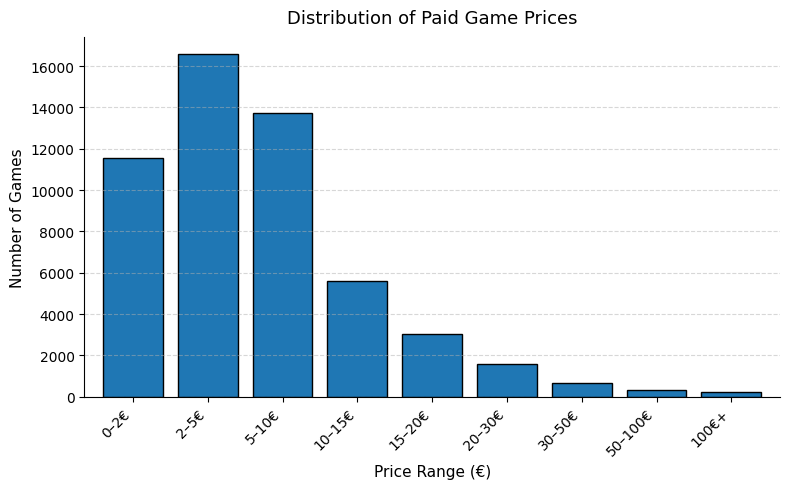

Number of free games: 11554


In [ ]:
free_games = steam_df.loc[steam_df['price'] == 0]
paid_games = steam_df.loc[steam_df['price'] > 0].copy()

average_price = paid_games['price'].mean()
print(f"Average price of a paid game: €{average_price:.2f}")

bins = [0, 2, 5, 10, 15, 20, 30, 50, 100, float('inf')]
labels = [
    "0–2€", "2–5€", "5–10€", "10–15€", "15–20€",
    "20–30€", "30–50€", "50–100€", "100€+"
]

paid_games.loc[:, 'price_bin'] = pd.cut(
    paid_games['price'],
    bins=bins,
    labels=labels,
    right=False
)

price_bin_counts = paid_games['price_bin'].value_counts().sort_index()

plt.figure(figsize=(8, 5))

price_bin_counts.plot(
    kind='bar',
    width=0.8,
    edgecolor='black'
)

plt.xlabel("Price Range (€)", fontsize=11)
plt.ylabel("Number of Games", fontsize=11)
plt.title("Distribution of Paid Game Prices", fontsize=13, pad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("price_distribution.png", dpi=300)

plt.show()

print(f"Number of free games: {len(free_games)}")


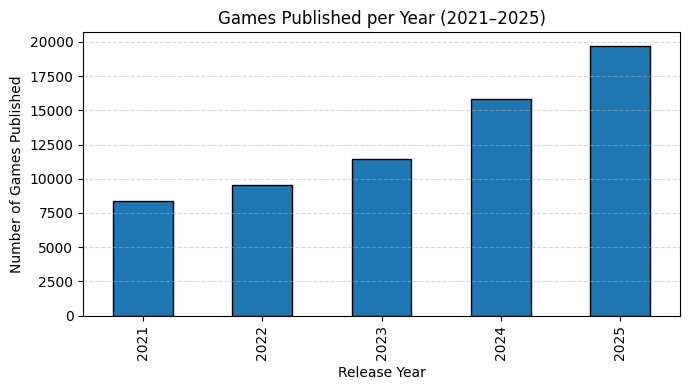

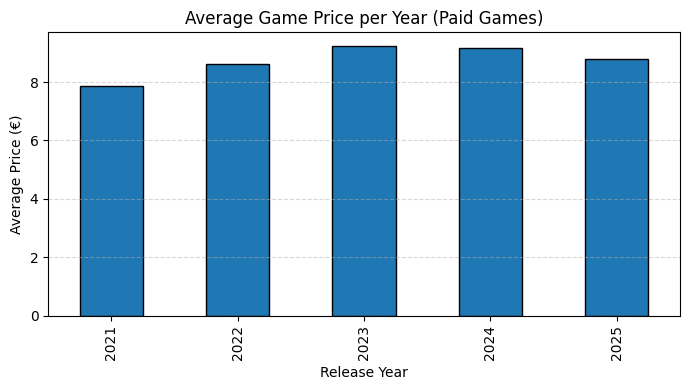

In [ ]:
yearly_counts = steam_df['year'].value_counts().sort_index()

avg_price_per_year = (
    steam_df[steam_df['price'] > 0]
    .groupby('year')['price']
    .mean()
)

plt.figure(figsize=(7, 4))
yearly_counts.plot(kind='bar', edgecolor='black')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Year (2021–2025)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("games_published_per_year.png", dpi=300)
plt.show()

plt.figure(figsize=(7, 4))
avg_price_per_year.plot(kind='bar', edgecolor='black')
plt.xlabel("Release Year")
plt.ylabel("Average Price (€)")
plt.title("Average Game Price per Year (Paid Games)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("avg_price_per_year.png", dpi=300)
plt.show()


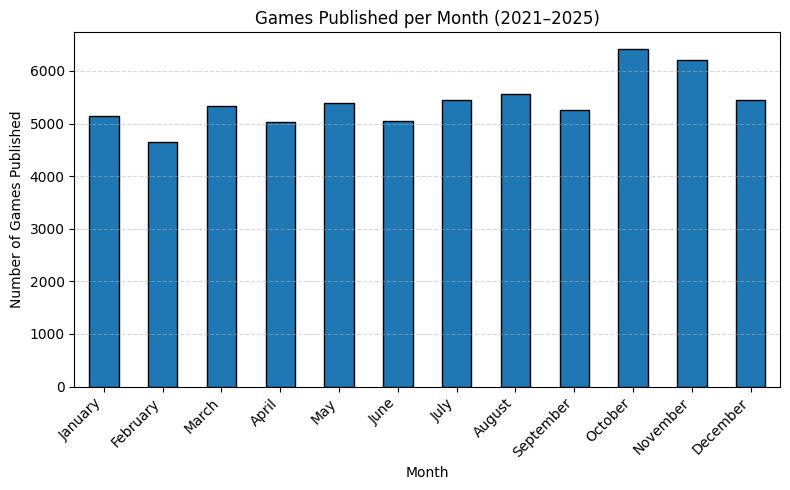

In [63]:
monthly_counts = steam_df['month'].value_counts()

months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_counts = monthly_counts.reindex(months_order)

plt.figure(figsize=(8, 5))
monthly_counts.plot(kind='bar', edgecolor='black')
plt.xlabel("Month")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Month (2021–2025)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("games_published_per_month.png", dpi=300)
plt.show()


In [ ]:
genre_lists = steam_df['genres'].str.split(';')

all_genres = sorted(set(g for genres in genre_lists for g in genres))
genre_index = {g: i for i, g in enumerate(all_genres)}

X = np.zeros((len(genre_lists), len(all_genres)), dtype=int)

for i, genres in enumerate(genre_lists):
    for g in genres:
        X[i, genre_index[g]] = 1

distance_matrix = pairwise_distances(X.T, metric='jaccard')

mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=42,
    normalized_stress="auto"
)
coords = mds.fit_transform(distance_matrix)

genre_counts = Counter(g for genres in genre_lists for g in genres)

k = 4
labels = KMeans(n_clusters=k, random_state=42).fit_predict(coords)

plt.figure(figsize=(14, 12))

sizes = [np.sqrt(genre_counts[g]) * 60 for g in all_genres]

scatter = plt.scatter(
    coords[:, 0],
    coords[:, 1],
    s=sizes,
    c=labels,
    cmap='tab10',
    alpha=0.8,
    edgecolors='black'
)

# Labels
for i, g in enumerate(all_genres):
    plt.text(
        coords[i, 0],
        coords[i, 1],
        g,
        ha='center',
        va='center',
        fontsize=9
    )

plt.title(
    "Genre Similarity Map\n"
    "(Node size = frequency, color = similarity cluster, distance = Jaccard co-occurrence)",
    fontsize=14,
    pad=15
)

plt.axis('off')
plt.tight_layout()
plt.savefig("genre_similarity_map.png", dpi=300)
plt.show()


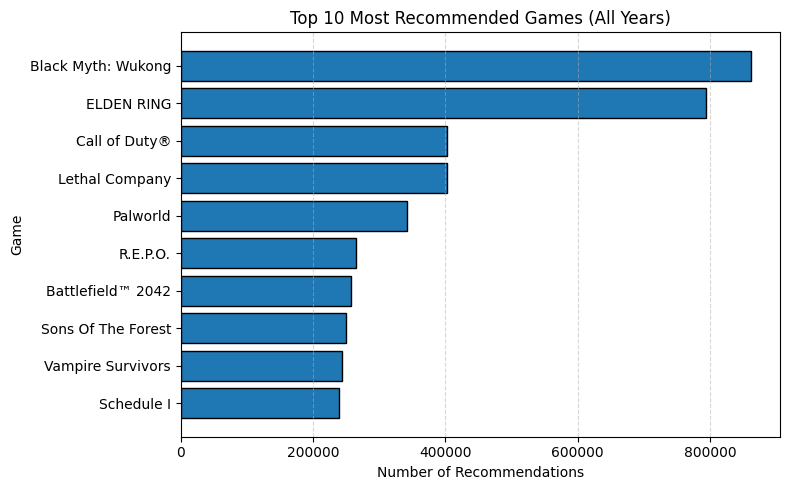

In [65]:
top_games = (
    steam_df[['name', 'recommendations']]
    .sort_values(by='recommendations', ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 5))
plt.barh(top_games['name'], top_games['recommendations'], edgecolor='black')
plt.xlabel("Number of Recommendations")
plt.ylabel("Game")
plt.title("Top 10 Most Recommended Games (All Years)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("top_10_recommended_games.png", dpi=300)
plt.show()


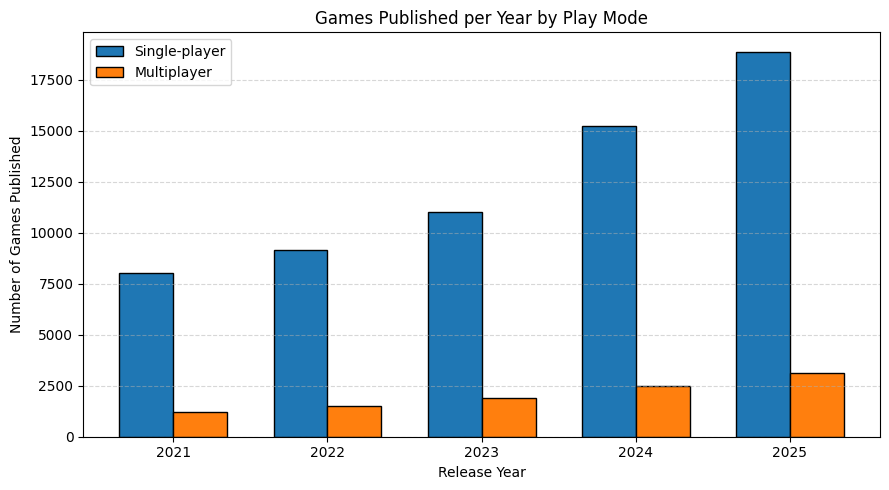

In [66]:
steam_df['is_single'] = steam_df['categories'].str.contains('Single-player', case=False, na=False)
steam_df['is_multi'] = steam_df['categories'].str.contains('Multi-player|Multiplayer', case=False, na=False)

yearly_counts = (
    steam_df
    .groupby('year')[['is_single', 'is_multi']]
    .sum()
    .sort_index()
)

years = yearly_counts.index
x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(
    x - width / 2,
    yearly_counts['is_single'],
    width,
    label='Single-player',
    edgecolor='black'
)

plt.bar(
    x + width / 2,
    yearly_counts['is_multi'],
    width,
    label='Multiplayer',
    edgecolor='black'
)

plt.xlabel("Release Year")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Year by Play Mode")
plt.xticks(x, years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("single_vs_multi_pa.png", dpi=300)
plt.show()
